## ReadCSV and preprocess

In [1]:
library(dplyr)
library(readr)
library(rjags)


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Warning message:
"package 'rjags' was built under R version 4.4.3"
Loading required package: coda

Linked to JAGS 4.3.1

Loaded modules: basemod,bugs



In [2]:
# Read your data
df <- read_csv("data.csv")

# Create team indices (important for modeling)
teams <- sort(unique(c(df$home_team, df$away_team)))
team_index <- setNames(seq_along(teams), teams)

df <- df %>%
  mutate(
    H = team_index[home_team],
    A = team_index[away_team]
  )


Rows: 1230 Columns: 15
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (3): game_date, home_team, away_team
dbl (12): game_id, fg3m_home, ftm_home, pts_home, fg3m_away, ftm_away, pts_a...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


## Model in JAGS for free throws

In [3]:
model_string_pois <- "
model {
  for (i in 1:N) {
    # Home
    HFT[i] ~ dpois(thetaH[i])
    log(thetaH[i]) <- att[H[i]] + def[A[i]] + c + home
    
    # Away
    AFT[i] ~ dpois(thetaA[i])
    log(thetaA[i]) <- att[A[i]] + def[H[i]] + c
  }

  # Priors
  for (j in 1:K) {
    att[j] ~ dnorm(mu_att, tau_att)
    def[j] ~ dnorm(mu_def, tau_def)
  }

  mu_att ~ dnorm(0, 0.0001)
  mu_def ~ dnorm(0, 0.0001)
  tau_att ~ dgamma(0.1, 0.1)
  tau_def ~ dgamma(0.1, 0.1)

  c ~ dnorm(2, 0.0001)
  home ~ dnorm(0, 0.0001) T(0,)

  # Identifiability constraints
  att[K+1] <- -sum(att[1:(K-1)])
  def[K+1] <- -sum(def[1:(K-1)]) 
}
"

## Prepare data for rjags

In [4]:
# Assume you've already processed your DataFrame as above
data_list <- list(
  N = nrow(df),
  K = length(teams)-1,
  HFT = df$fg3m_home,
  AFT = df$fg3m_away,
  H = df$H,
  A = df$A
)

# Run model
model <- jags.model(textConnection(model_string_pois), data = data_list, n.chains = 3)
update(model, 5000)  # Burn-in

samples_pois <- coda.samples(model, variable.names = c("att", "def", "home", "c"), n.iter = 1000)
summary(samples_pois)


Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 2460
   Unobserved stochastic nodes: 64
   Total graph size: 8476

Initializing model




Iterations = 6001:7000
Thinning interval = 1 
Number of chains = 3 
Sample size per chain = 1000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

             Mean      SD  Naive SE Time-series SE
att[1]   0.095987 0.04044 0.0007383      0.0012762
att[2]  -0.002344 0.04182 0.0007636      0.0013434
att[3]  -0.093987 0.04410 0.0008051      0.0012211
att[4]  -0.090169 0.04174 0.0007621      0.0013828
att[5]   0.187756 0.03893 0.0007108      0.0012682
att[6]   0.054717 0.03979 0.0007264      0.0012060
att[7]   0.020329 0.04082 0.0007453      0.0013108
att[8]  -0.350293 0.04930 0.0009002      0.0018998
att[9]   0.019769 0.04083 0.0007455      0.0014115
att[10]  0.133440 0.03895 0.0007111      0.0012373
att[11]  0.192593 0.03772 0.0006887      0.0011302
att[12] -0.009032 0.04197 0.0007662      0.0012591
att[13]  0.015303 0.04091 0.0007468      0.0012916
att[14] -0.291067 0.04749 0.0008670      0.0015672
att[15]  0.081708 0.03965 0.0007238   

In [ ]:
#coda::gelman.diag(samples_pois)  # > 1.1, problem with posterior

ERROR: Error in chol.default(W): the leading minor of order 61 is not positive


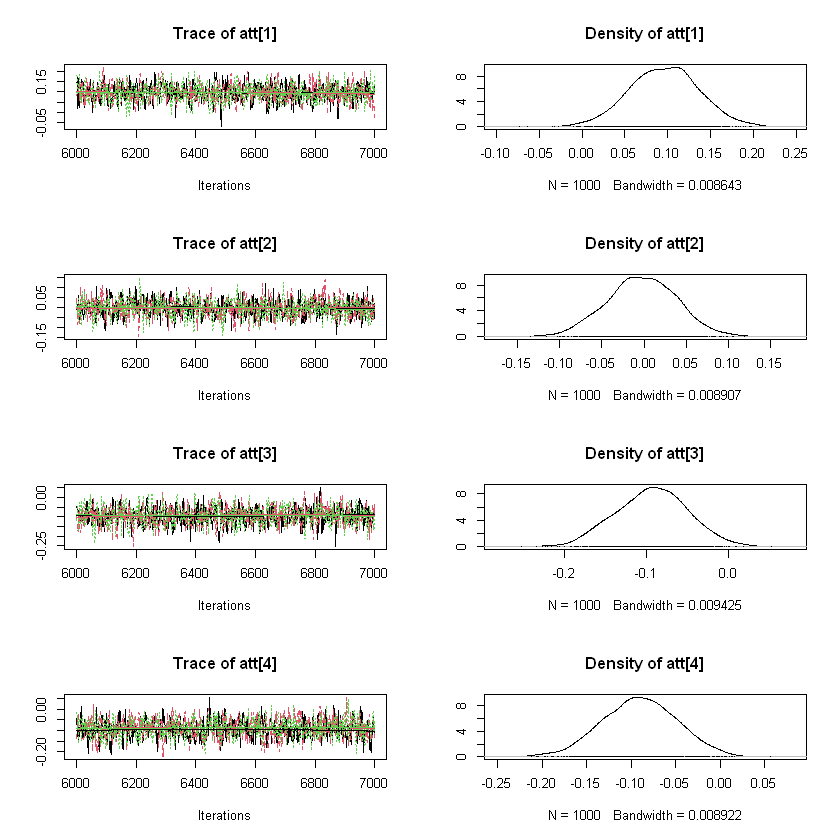

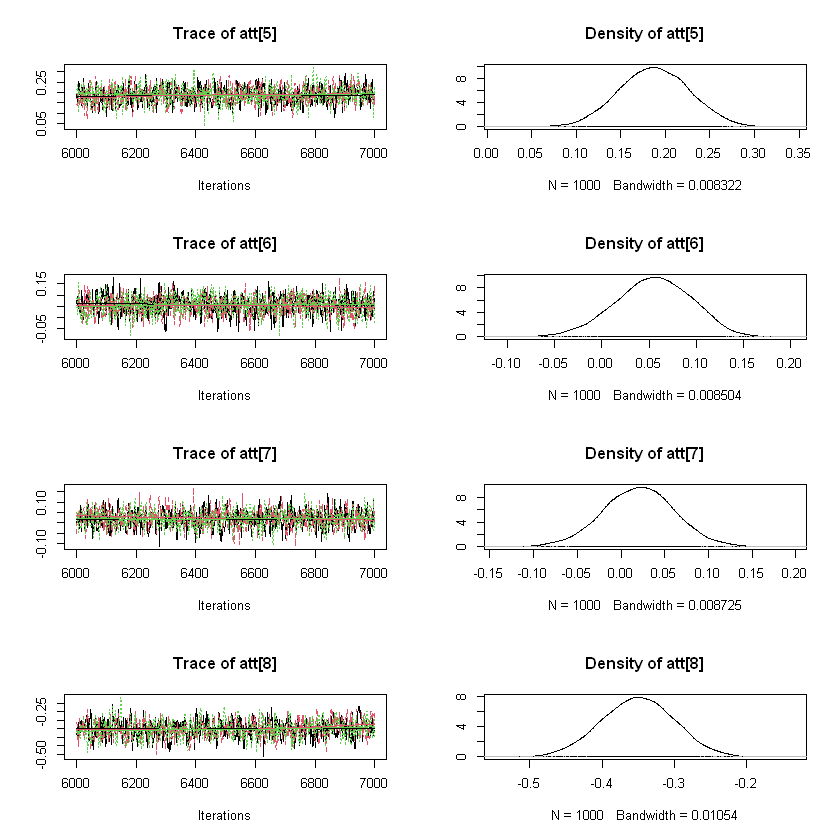

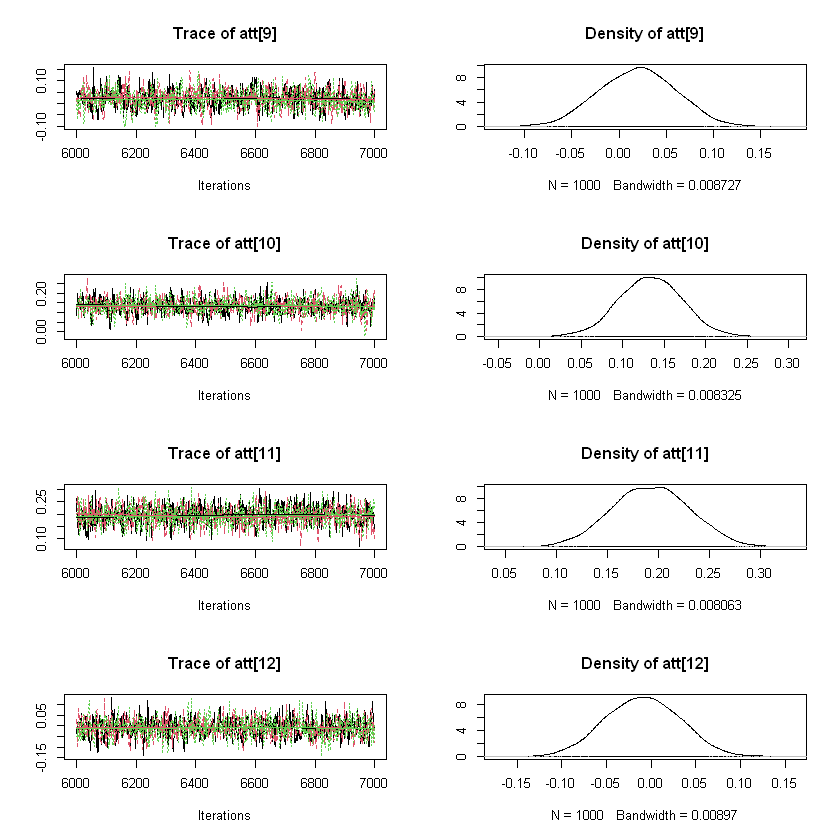

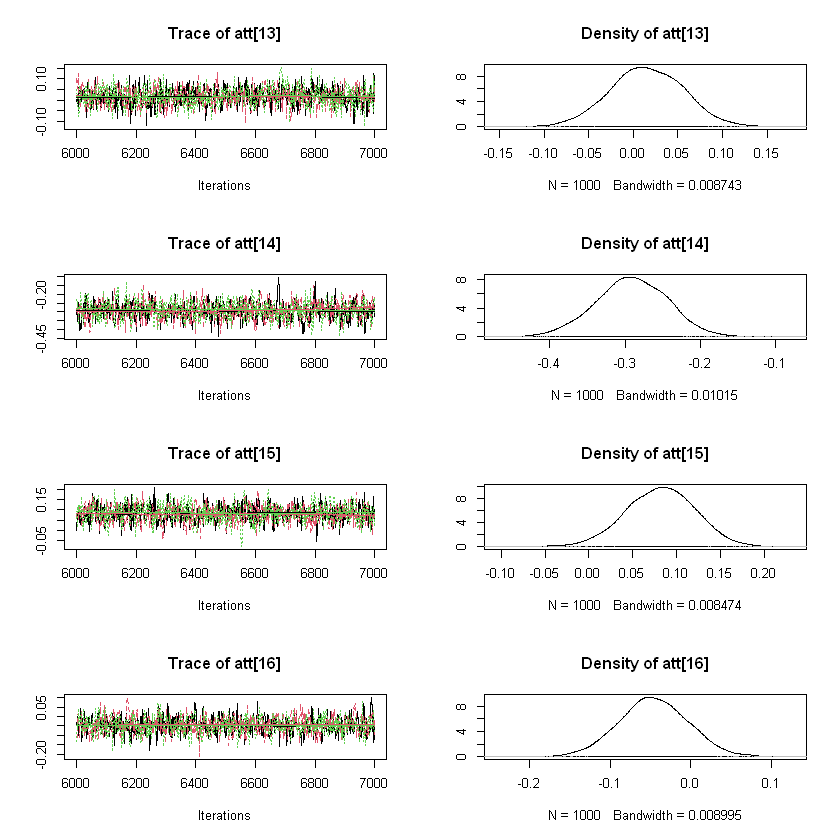

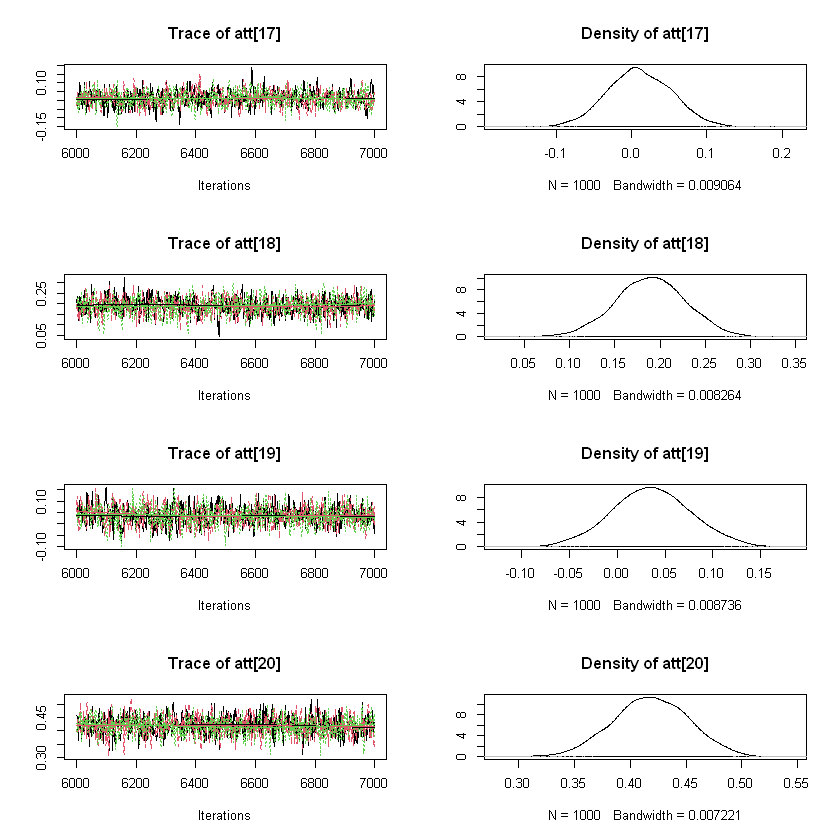

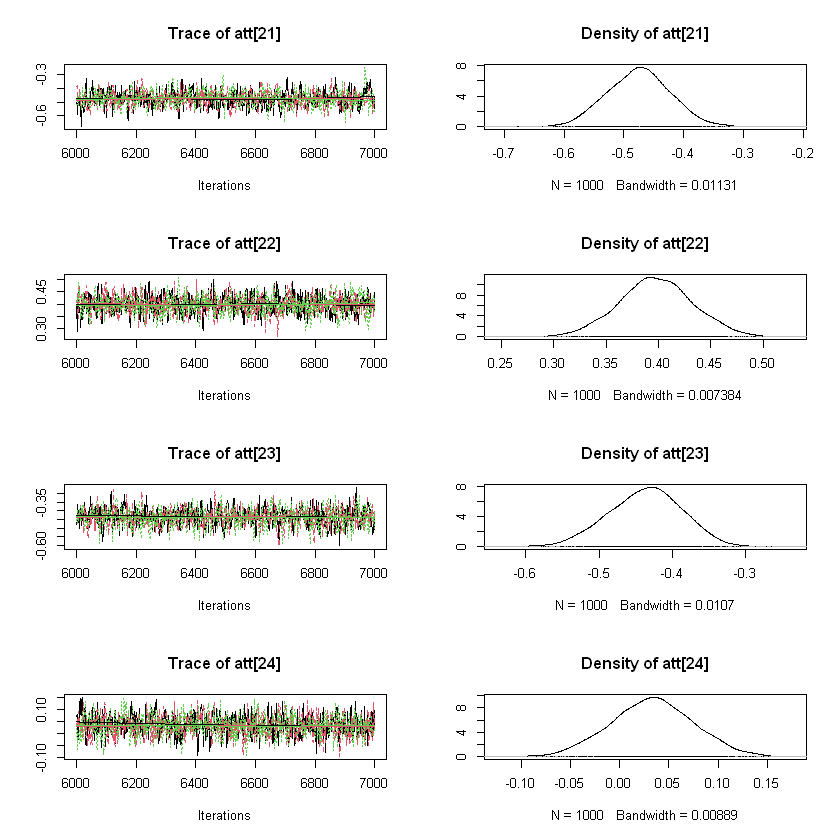

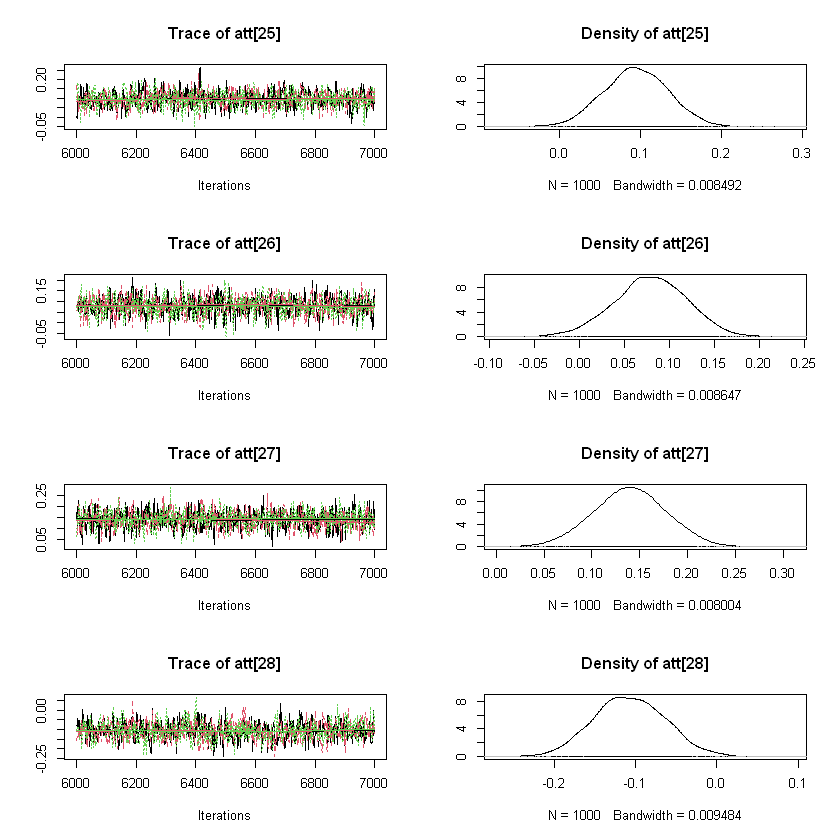

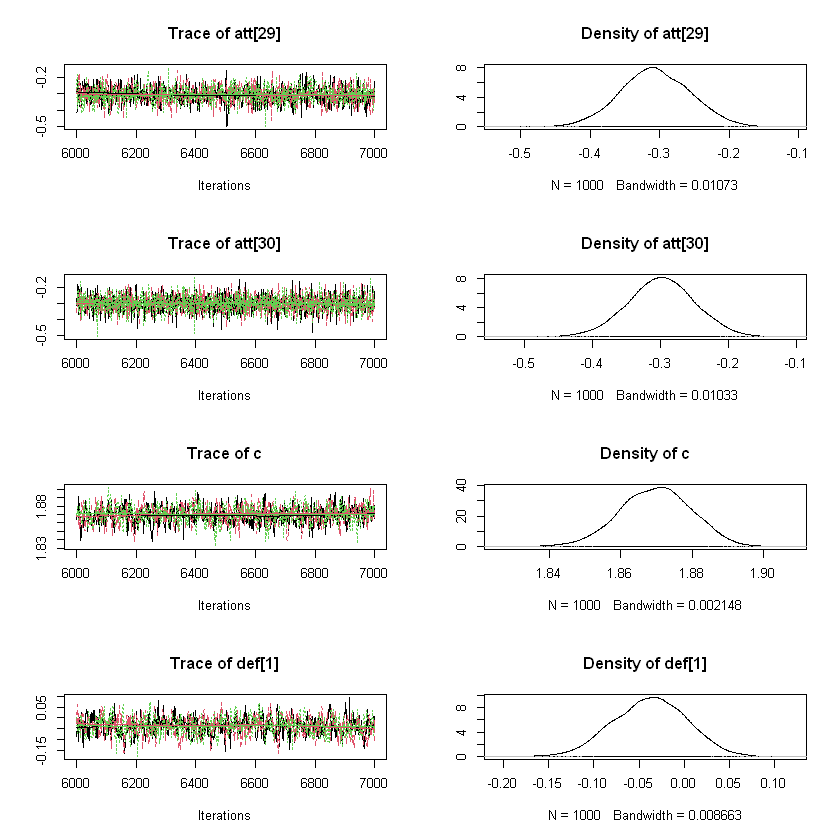

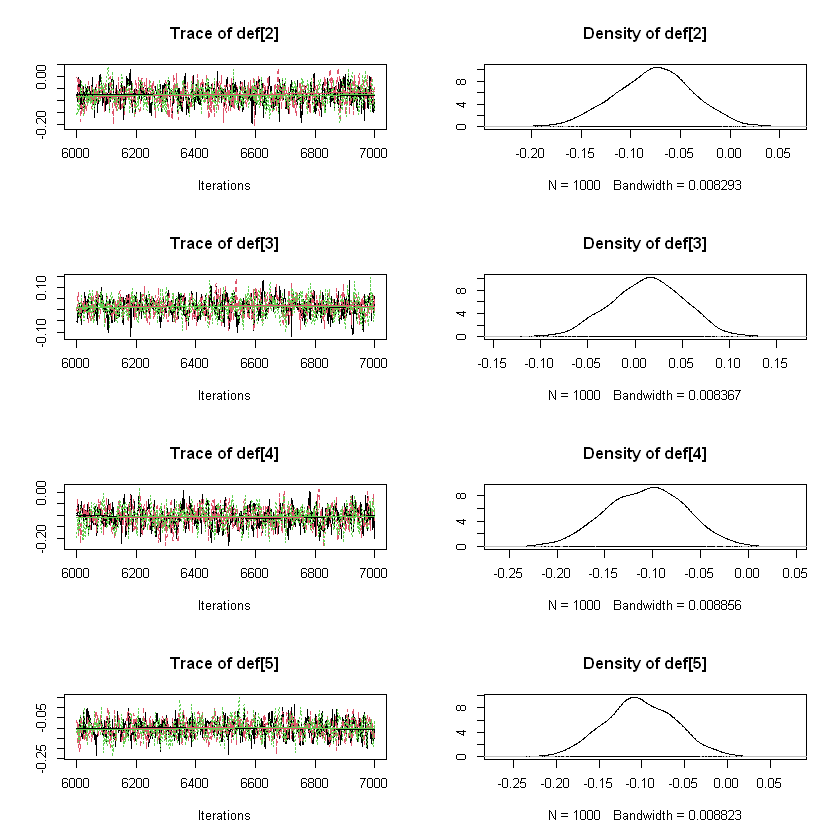

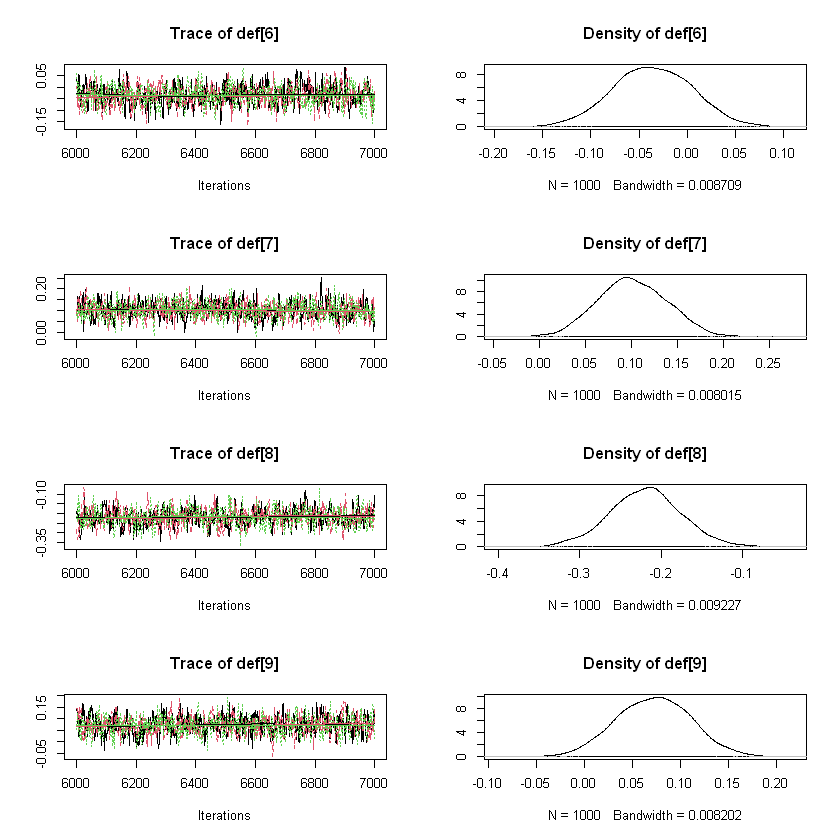

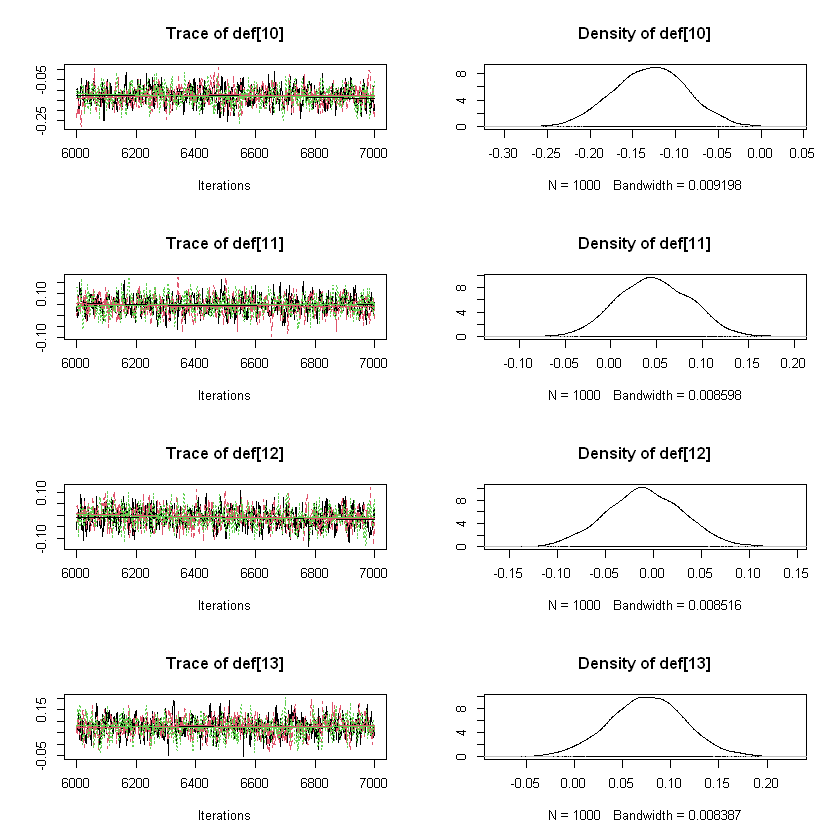

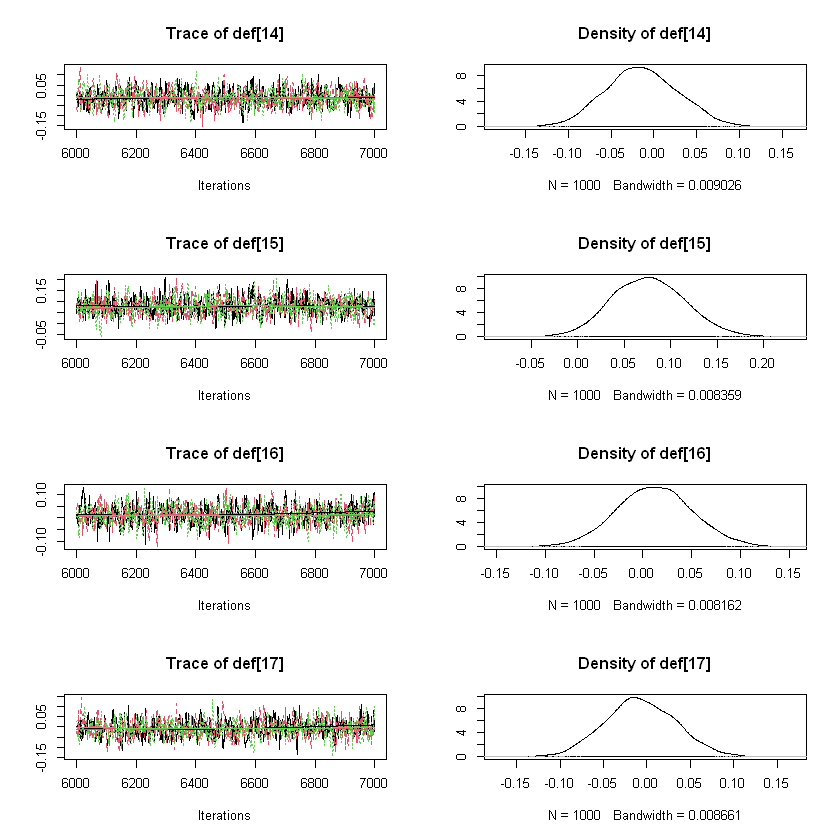

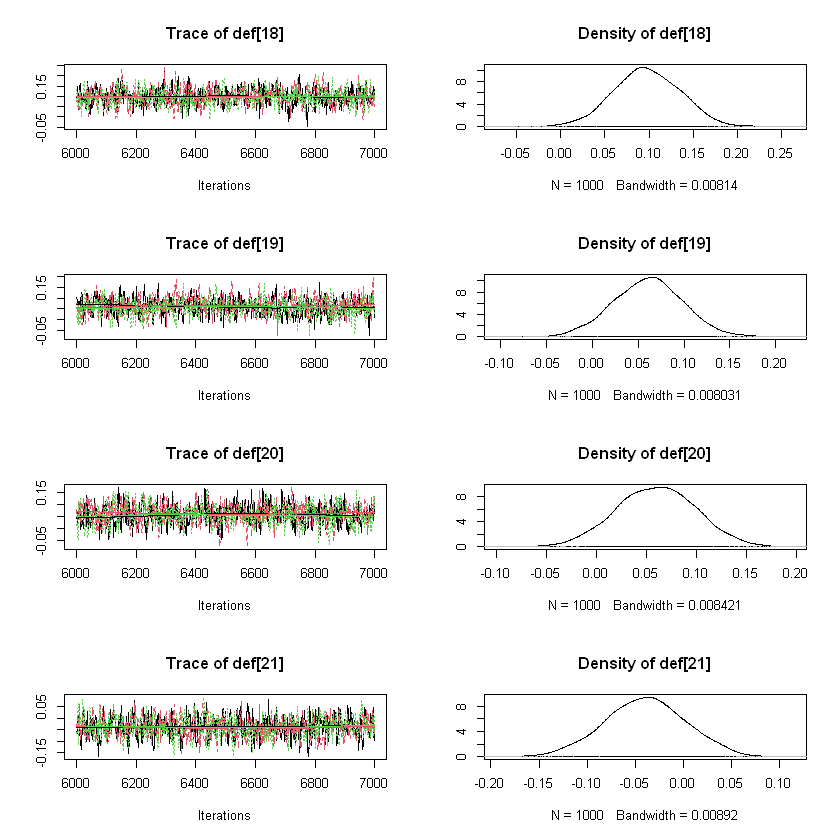

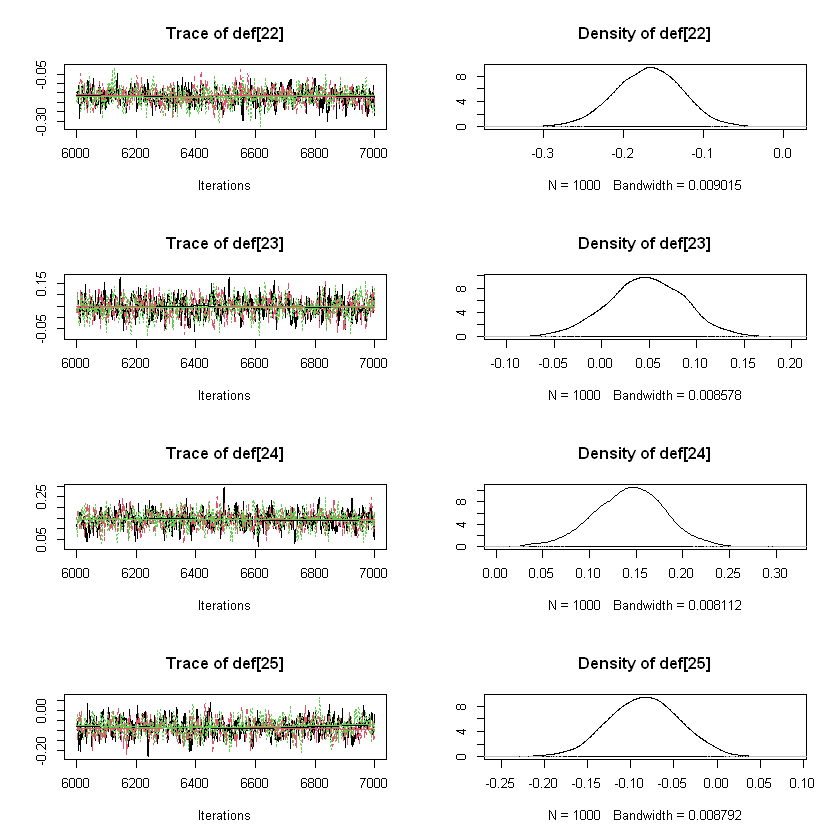

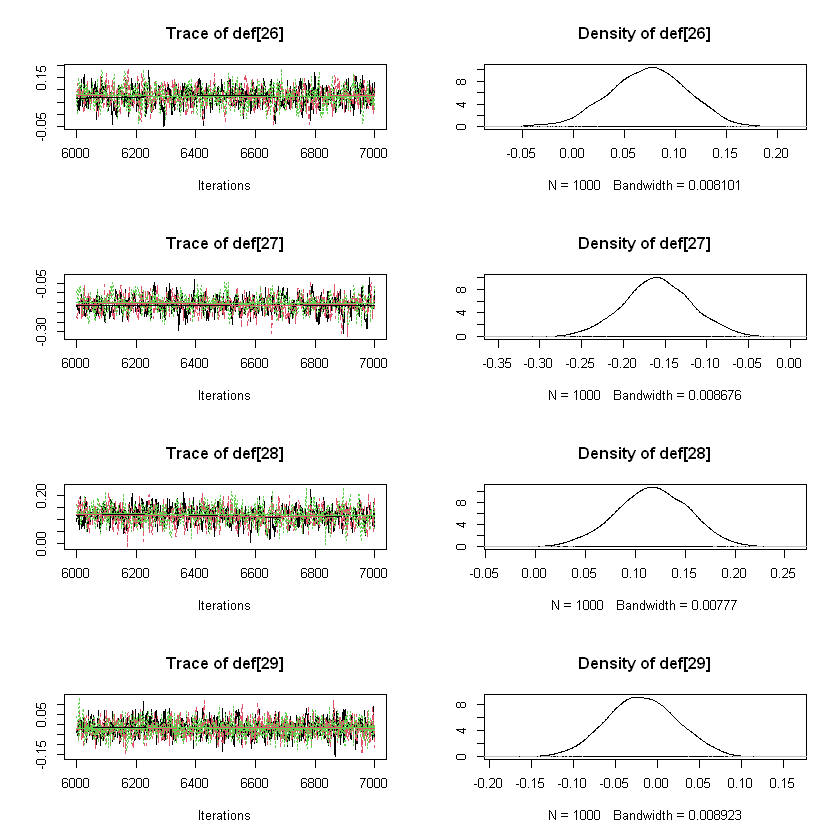

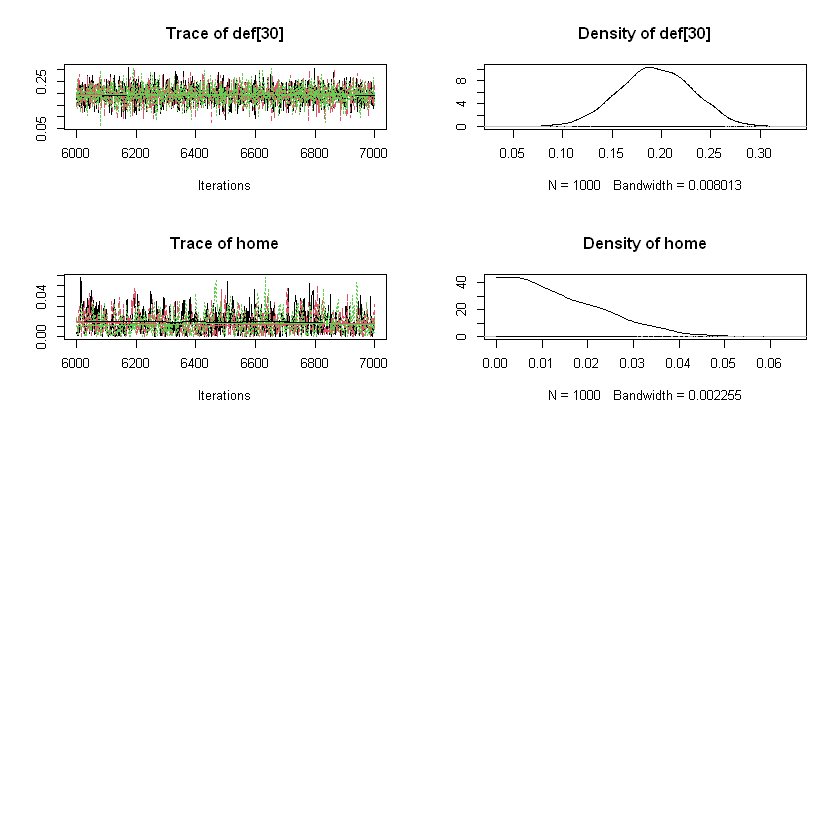

In [6]:
par(bg = 'white')
plot(samples_pois)

In [7]:
#jpeg('Pois_FT_trace_density.jpeg')
#par(bg = 'white')
#plot(samples_pois)
#dev.off()

## Estimate RMSE

In [8]:
"   
    # Home
    HFT[i] ~ dpois(thetaH[i])
    log(thetaH[i]) <- att[H[i]] + def[A[i]] + c + home
    
    # Away
    AFT[i] ~ dpois(thetaA[i])
    log(thetaA[i]) <- att[A[i]] + def[H[i]] + c
"

[1] "   \n    # Home\n    HFT[i] ~ dpois(thetaH[i])\n    log(thetaH[i]) <- att[H[i]] + def[A[i]] + c + home\n    \n    # Away\n    AFT[i] ~ dpois(thetaA[i])\n    log(thetaA[i]) <- att[A[i]] + def[H[i]] + c\n"

In [9]:
N = nrow(df)
K = length(teams)

mean_vals_att <- summary(samples_pois)$statistics[1]
mean_vals_def <- summary(samples_pois)$statistics[32]

for (i in 2:K){
    mean_vals_att <- c(mean_vals_att, summary(samples_pois)$statistics[i])
}

for (j in 33:61){
    mean_vals_def <- c(mean_vals_def, summary(samples_pois)$statistics[j])
}

c_val <- summary(samples_pois)$statistics[31]
home_val <- summary(samples_pois)$statistics[62]

In [10]:
#write(mean_vals_att, 'Pois_FT_att.txt')
#write(mean_vals_def, 'Pois_FT_def.txt')
#write(c_val, 'Pois_FT_c.txt')
#write(home_val, 'Pois_FT_home.txt')

In [11]:
write.csv(mean_vals_att, 'Pois_3p_att.csv')
write.csv(mean_vals_def, 'Pois_3p_def.csv')
write.csv(c_val, 'Pois_3p_c.csv')
write.csv(home_val, 'Pois_3p_home.csv')

In [12]:
# estimate theta[i] ~ exp(att[H[i]] + def[A[i]] + c + home)
theta_1 = exp(mean_vals_att[1] + mean_vals_def[4] + c_val + home_val)
theta_1

[1] 6.505077

In [13]:
#install.packages("Metrics")
#library(Metrics)

In [14]:
#actual <- df$ftm_home

#rmse_value <- rmse(actual, predicted)